In [9]:
'''
Analyze force-xxx experiement of ATI Nano-17 force sensor 
Author: Yitian Shao
Created on 2022.09.29 based on 'NanoForceSensor'
'''

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import scipy.io as scio
from scipy import signal
import seaborn as sns

plt.rc('font', size=10, family='Verdana') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
plt.rc('axes', edgecolor='k', linewidth=0.75, labelcolor='k')
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['errorbar.capsize'] = 4

figSize_inch = (3.2, 2.4)

In [10]:
'''
General Functions
'''

def aPlot(figName='', is3D = False, dpi=72):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3), dpi=dpi)
    
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def lowpassSmooth(datain, cutFreqRatio = 0.05, order = 8):
    b, a = signal.butter(order, 2 * cutFreqRatio, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def decodeData(fileName, numFormat, frontCode='', rearCode=''):
    segStr = re.findall(frontCode+numFormat+rearCode, fileName)
    if segStr:
        numData = float(re.findall(numFormat, segStr[0])[0])
    else:
        numData = None
    return numData

def cutRepeatTrial(datain, Fs, expectedTrialNum, disp=False, axis=2):
    rawData = -datain[:,axis]
    
    smData = lowpassSmooth(rawData, cutFreqRatio = (10/Fs), order = 8)
    
    smData = smData - smData[0]
    
#     smData = signal.detrend(smData, type='linear')
    
    samp = np.arange(len(rawData))
    
    maxRawValue = np.max(smData)
    
    ''' Fine tunning needed for individual measurement session'''
    segPointInd = np.squeeze(np.argwhere(smData[10:] > 0.25 * maxRawValue)) # Find value larger than 25% of peak as valid segment data point
    segGapInd = np.squeeze(np.argwhere(np.diff(segPointInd) > 1))# Index of point where large gap occurs (end and start of a seg)
    cutInd = (0.5 * (segPointInd[segGapInd] + segPointInd[segGapInd+1])).astype(int) # Cut in the middle of a end and a start point
    
    if not isinstance(cutInd,np.ndarray) or len(cutInd) < expectedTrialNum-1:
        if disp:
            ax0, _ = aPlot(); 
            ax0.plot(samp, rawData, color='k'); 
            plt.show();       
        return []
    
    if len(cutInd) > expectedTrialNum-1:
        cutInd = cutInd[:expectedTrialNum]
    elif len(cutInd) == expectedTrialNum-1:
        cutInd = np.insert(cutInd, expectedTrialNum-1, len(rawData)-1)

    avgSegLen = np.mean(np.diff(cutInd))
    cutInd = np.insert(cutInd, 0, max(cutInd[0]-avgSegLen, 0))
    
    if disp:
        ax0, _ = aPlot(); 
        ax0.plot(samp, rawData, color='k'); 
        ax0.plot(samp, smData, color='tab:blue')
        ax0.plot(cutInd, np.zeros(cutInd.shape), '*r')
        plt.show();
    
    return cutInd

def getDataArray(dFrame, indList, colName, toFlat=False):
    compValue = (dFrame.loc[indList,colName]).to_numpy()  
    
    if toFlat:
        flatValue = []
        for aRow in compValue:
            flatValue.extend(aRow)
        flatValue = np.array(flatValue)
        return flatValue
            
    return compValue
    
def getMeanSTD(compValue): # Compute errorbar of data mixing all conditions (rows of input array)
    if len(compValue) == 0:
        return None, None
        
    compValue = np.array(compValue)
    
    meanValue = np.mean(compValue)
    stdValue = np.std(compValue)
    
    return meanValue, stdValue

In [12]:
'''
Load, preprocess and segment force sensor data
'''

# measureDataPath = './ForceData20220929Voltage'
# Fs = 1000 

measureDataPath = './ForceData20220930Frequency'
Fs = 2000 # Sampling frequency of the Nano sensor is set to be 2000 Hz for frequency response characterization

# measureDataPath = './ForceData20201006Frequency'
# Fs = 10000 # Sampling frequency of the Nano sensor is set to be 10000 Hz for frequency response characterization

nanoData = []

''' Data preprocess and segmentation '''
for root, directories, files in walk(measureDataPath):
    for fileName in files:
        measureDate = decodeData(fileName, '\d{4}', rearCode='2022')
        tubeLen = decodeData(fileName, '\d+', rearCode='mm')
        infillVol = decodeData(fileName, '[\d+\.]*\d+', rearCode='mL') 
        pulseFreq = decodeData(fileName, '[\d+\.]*\d+', rearCode='mHz')  
        
        sinFreq = decodeData(fileName, '[\d+\.]*\d+', rearCode='Hz') 
        voltage = decodeData(fileName, '[\d+\.]*\d+', rearCode='kV') 

        trialNum = decodeData(fileName, '\d+', rearCode='.mat') # ForceData20220929
        if trialNum is None:
            trialNum = 1
            
        isSilInsulated = re.findall('Sil', fileName)
        data = []
        
        dLabel = ""
        if tubeLen is not None:
            dLabel = dLabel + ("%dmm" % tubeLen)    
        if infillVol is not None:
            dLabel = dLabel + ("%.2fmL" % infillVol)           
        if sinFreq is not None:
            dLabel = dLabel + ("%.1fHz" % sinFreq)
        if voltage is not None:
            dLabel = dLabel + ("%.1fkV" % voltage)
        if isSilInsulated:
            dLabel = dLabel + "Sil"

        print("%s - trial%s" % (dLabel, trialNum))

    
        
        matData = scio.loadmat(ospa.join(root, fileName))
        if matData:
            forceData = matData['forceNano']
            
            if re.findall('Frequency', measureDataPath):
                data.append(forceData)  
            else:
                cutInd = cutRepeatTrial(forceData, Fs, 6, disp=True, axis=2)
                segNum = len(cutInd)-1

                if segNum > 0: 
                    for j in range(segNum):
                        segData = forceData[cutInd[j]:cutInd[j+1],:]
                        data.append(segData)  
        
        nanoData.append([dLabel, tubeLen, sinFreq, voltage, trialNum, data])

nanoData = pd.DataFrame(nanoData, columns = ['Label', 'TubeLength_mm', 'SinFreq_Hz', 'Voltage_kV','Trial','Data'])  

nanoData.head(20)

100mm0.0Hz7.0kV - trial1
100mm100.0Hz7.0kV - trial1
100mm500.0Hz7.0kV - trial1
100mm500.0Hz7.0kV - trial2.0


,Label,TubeLength_mm,SinFreq_Hz,Voltage_kV,Trial,Data
0,100mm0.0Hz7.0kV,100.0,0.0,7.0,1.0,"[[[2.241665937941604e-05, -0.00437255558770327..."
1,100mm100.0Hz7.0kV,100.0,100.0,7.0,1.0,"[[[0.0022895613370199895, 0.002574655771117898..."
2,100mm500.0Hz7.0kV,100.0,500.0,7.0,1.0,"[[[0.03561045831838117, 0.009632854880733533, ..."
3,100mm500.0Hz7.0kV,100.0,500.0,7.0,2.0,"[[[-0.0005867333312763301, 0.00639828798230524..."


In [ ]:
# print(nanoData.loc[nanoData['TubeLength_mm']==100, 'SinFreq_Hz'].sort_values().values)

['100mm0.0Hz7.0kV' '100mm100.0Hz7.0kV' '100mm500.0Hz7.0kV']


,Label,TubeLength_mm,SinFreq_Hz,FreqMag
0,100mm0.0Hz7.0kV,100.0,0.0,[0.018573867219027002]
1,100mm100.0Hz7.0kV,100.0,100.0,[0.0036648347534935432]
2,100mm500.0Hz7.0kV,100.0,500.0,"[0.02414538239623144, 0.0075148920833246835]"


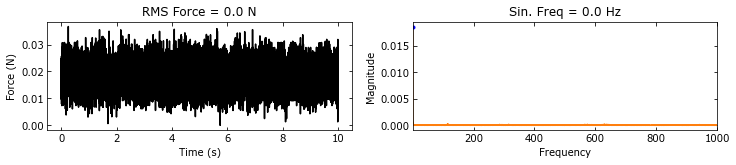

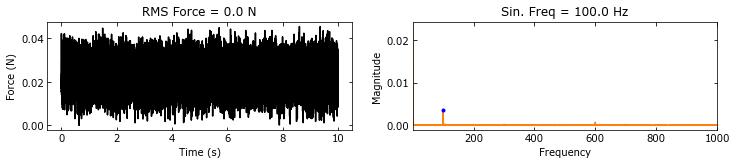

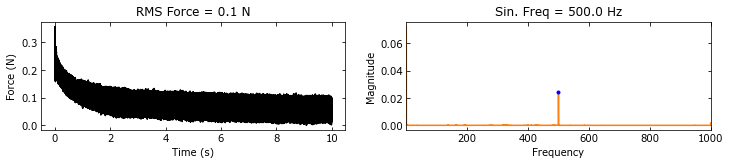

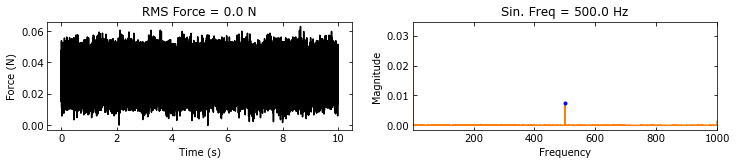

In [13]:
'''(Exclusive) Frequency response characteristics for the actuator'''
def freqResponse(dframe, dispFrequencies, yColName, yColSelect):
    dispFreqMag = []
    for aFreq in dispFrequencies:
        freqMag = dframe.loc[(dframe['SinFreq_Hz'] == aFreq) & (dframe[yColName] == yColSelect)
                                  , 'FreqMag'].values[0][0].tolist()
        dispFreqMag.append(freqMag)

    dispFreqMag = np.array(dispFreqMag)
    dispLogMag = 20*np.log10(dispFreqMag)
    dispLogMag = dispLogMag-dispLogMag[0]
    return dispLogMag, dispFreqMag

labels = nanoData.Label.unique()
print(labels)

dataFeature = []

sensorAxis = 2

concateSignal = np.empty([0, 1], dtype=float)

for aLabel in labels:
    selectedData = nanoData.loc[(nanoData['Label'] == aLabel)]
    
    freqMag = []
    
    for index, row in selectedData.iterrows():
        for aSignal in row["Data"]:   
            y = -aSignal[:,sensorAxis]
            y = y - np.amin(y)
            RMSforce = np.sqrt(np.mean(y**2))
            
            concateSignal = np.append(concateSignal, y)
            
            _, ax1 = plt.subplots(1,2, dpi=72, figsize=(12,2))
            ax1[0].plot((np.arange(len(y))/Fs),y, 'k')
            ax1[0].set_xlabel('Time (s)')
            ax1[0].set_ylabel('Force (N)')
            ax1[0].set_title('RMS Force = %.1f N' % RMSforce)
            
            spectr, f, _ = ax1[1].magnitude_spectrum(y, Fs=Fs, color='C1')
            idx = (np.abs(row['SinFreq_Hz'] - np.array(f))).argmin()
            freqMagValue = spectr[idx]
            
#             freqMagValue = RMSforce

            if (freqMagValue.size) > 0:
                ax1[1].plot(row['SinFreq_Hz'], freqMagValue, '.b')    
            ax1[1].set_xlim([0.1, Fs/2])
            ax1[1].set_ylabel("Magnitude")
            ax1[1].set_title('Sin. Freq = %.1f Hz' % row['SinFreq_Hz'])
            
            freqMag.append(freqMagValue)
            
    dataFeature.append([aLabel, row["TubeLength_mm"], row['SinFreq_Hz'], freqMag])

dataFeature = pd.DataFrame(dataFeature, columns = ['Label', 'TubeLength_mm','SinFreq_Hz','FreqMag'])  

dataFeature.head(10)

In [ ]:
'''Produce frequency response plot'''
octaveFrequencies = [4.000e-01, 6.000e-01, 1.000e+00, 1.600e+00, 2.000e+00, 2.500e+00, 3.200e+00,
                     4.000e+00, 5.000e+00, 6.300e+00, 7.900e+00, 1.000e+01, 1.260e+01, 1.580e+01,
                     2.000e+01, 2.510e+01, 3.160e+01, 4.000e+01, 5.010e+01, 6.310e+01, 7.940e+01,
                     1.000e+02, 1.259e+02, 1.585e+02, 2.000e+02, 2.512e+02, 3.162e+02, 3.981e+02,
                     5.012e+02, 6.310e+02, 7.943e+02, 1.000e+03]

dispFrequencies = [0.4, 1, 2, 4, 10, 20, 40, 100, 200, 400, 1000]

dispLogMag100,_ = freqResponse(dataFeature, octaveFrequencies, 'TubeLength_mm', 100)
x100 = np.log10(octaveFrequencies) #np.arange(len(dispFrequencies)) 

dispLogMag110,_ = freqResponse(dataFeature, octaveFrequencies, 'TubeLength_mm', 110)
x110 = np.log10(octaveFrequencies) #np.arange(len(dispLogMag110)) 
  
xTicks = np.log10(dispFrequencies)
xLabel = 'Frequency (Hz)'

colors = sns.color_palette('hls', n_colors=2)

fig1, ax1 = plt.subplots(dpi=300, figsize=(5,1))
# ax1.plot(x, dispFreqMag, 'k');  ax1.set_ylabel('Magnitude')
ax1.plot(x100, dispLogMag100, '.-', c=colors[0])
ax1.plot(x110, dispLogMag110, '.-', c=colors[1])
ax1.set_ylabel('Magnitude (dB)')

ax1.set_xlabel(xLabel)
ax1.set_xticks(xTicks);
ax1.set_xticklabels(dispFrequencies);

ax1.legend(labels=['100mm','110mm'], frameon=False, bbox_to_anchor=(1.0, 0.9), loc='upper left');
fig1.savefig("freq_response_100110.pdf", bbox_inches='tight')

In [ ]:
# '''Frequency reponse of concatenated signals (Not working)'''
# print(concateSignal.shape)
# fig2, ax2 = plt.subplots(dpi=300, figsize=(5,1))

# ax2.magnitude_spectrum(concateSignal[:560000], Fs=Fs, color=colors[0], scale='dB')
# ax2.magnitude_spectrum(concateSignal[560000:], Fs=Fs, color=colors[1], scale='dB')
# ax2.set_xlim([0.4, 1000])
# ax2.set_ylabel('Magnitude (dB)');

In [ ]:
'''Feature extraction from signals: peak value, time-averaged value, rising time'''

labels = nanoData.Label.unique()
print(labels)

dataFeature = []

for aLabel in labels:
    selectedData = nanoData.loc[(nanoData['Label'] == aLabel)]

    peakF = []
    rawPeakF = []
    tavgF = []
    triseF = []
    smF = []
        
    for index, row in selectedData.iterrows():
        for aSignal in row["Data"]:
            smData = lowpassSmooth(-aSignal[:,2], cutFreqRatio = (20/Fs), order = 10) # Use the z-axis force measurement 
            smData = smData - smData[0]

            maxValue = np.max(smData)
            onsetInd = np.argwhere(smData[50:] > 0.20 * maxValue)[0][0]+50 # When signal reach 10% of its peak (onset)

            PP80Ind = np.argwhere(smData[50:] > 0.80 * maxValue)[0][0]+50 # When signal reach 90% of its peak

            peakInd = np.argmax(smData)
            peakValue = np.max(smData)           
            rawPeakValue = np.max(-aSignal[:peakInd,2])

            riseTime = (PP80Ind - onsetInd)/Fs
            
            tavgValue = np.mean(smData[onsetInd:PP80Ind]) # -aSignal[onsetInd:PP80Ind,2]
            
            peakF.append(peakValue)
            rawPeakF.append(rawPeakValue)
            tavgF.append(tavgValue)
            triseF.append(riseTime)
            smF.append(smData)
            
            ax1,_ = aPlot(dpi=72)
            ax1.plot(-aSignal[:,2]+aSignal[0,2], 'k')
#             ax1.plot([1, peakInd], [peakValue, peakValue], '--b')
            ax1.plot([1, peakInd], [rawPeakValue, rawPeakValue], '--c')
#             ax1.plot(smData, 'g')
#             ax1.plot([onsetInd, onsetInd], [0, maxValue], '-r')
#             ax1.plot([PP80Ind, PP80Ind], [0, maxValue], '-r')
            ax1.set_xlabel("%s: peak=%.2fN , tAvg=%.2fN , riseT=%.3fs" % (aLabel, peakValue,tavgValue,riseTime))
            ax1.set_xlim([onsetInd-100, peakInd + 400])
            ax1.set_ylabel("Force (N)")
            plt.show()
            
    dataFeature.append([aLabel, row["TubeLength_mm"], row["Voltage_kV"], peakF, rawPeakF, tavgF, triseF, smF])

dataFeature = pd.DataFrame(dataFeature, columns = ['Label', 'TubeLength_mm','Voltage_kV','PeakForce','RawPeakForce','AvgForce','TriseForce','Data'])  

dataFeature.head(10)

In [ ]:
'''
Functions for Computing and Visualizing Errorbar
'''
def computeErrorbar1Var(dframe, xColName, xColList, zColName):
    dMean = []
    dSTD = []
    
    for x in xColList:
        selectInd = (dframe[xColName] == x)

        compValue = getDataArray(dframe, selectInd, zColName, toFlat=True)  

        valueMean, valueSTD = getMeanSTD(compValue)

        dMean.append(valueMean)
        dSTD.append(valueSTD)
    
    dMean = np.array(dMean)
    dSTD = np.array(dSTD)
    
    return dMean, dSTD

def computeErrorbar(dframe, xColName, xColList, yColName, yColList, zColName):
    dMean = []
    dSTD = []
    
    for x in xColList:
        dMean.append([])
        dSTD.append([])
        for y in yColList:
            selectInd = (dframe[xColName] == x) & (dframe[yColName] == y)

            compValue = getDataArray(dframe, selectInd, zColName, toFlat=True)  
            
            valueMean, valueSTD = getMeanSTD(compValue)
            
            dMean[-1].append(valueMean)
            dSTD[-1].append(valueSTD)
    
    dMean = np.array(dMean)
    dSTD = np.array(dSTD)
    
    return dMean, dSTD

def dispErrorbar(ax, x, dMean, dErr, xLabel, xLabelStr, yLabelStr, zLabel, colorPalette=None, style='.-', 
                 dispLegend=True, xShift=[0.1,0.4]):
    yLen = len(yLabelStr)
    
    colors = sns.color_palette(colorPalette, n_colors=yLen)
    
    ax.set_ylabel(zLabel, color='k')
    ax.tick_params(axis='y', labelcolor='k')
    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color('k') 
    ax.spines['right'].set_color('k')
    ax.spines['left'].set_color('k')

    pltHandles = []
    for i in np.arange(yLen):
        pltHandles.append(ax.plot(2*x + (i * xShift[0]), dMean[i], style, c=colors[i])[0])
        (ax.errorbar(2*x + (i * xShift[0]), dMean[i], yerr=dErr[i], fmt='none', ecolor=colors[i], capsize=0)[0]) 
        
    ax.set_xlabel(xLabel)
    ax.set_xticklabels(xLabelStr, rotation=0);
    ax.set_xticks(2*x + xShift[1]);

    if dispLegend:
        ax.legend(handles=reversed(pltHandles), labels=reversed(yLabelStr), frameon=False, bbox_to_anchor=(1.02, 1.0), 
                  loc='upper left');
    
    return ax

In [ ]:
'''
Analysis for Visualizing the Errorbar of multiple actuator types
'''
labels = ['100mm3.0kV', '100mm4.0kV', '100mm5.0kV', '100mm6.0kV', '100mm7.0kV',
          '110mm3.0kV', '110mm4.0kV', '110mm5.0kV', '110mm6.0kV', '110mm7.0kV']

vLevels = [3, 4, 5, 6, 7]
tLengths = [100, 110]

colorSet = 'hls'
style = '.-'

x = np.arange(len(vLevels))
xLabelStr = np.array(vLevels)
yLabelStr = tLengths
xLabel = 'Voltage (kV)'


meanPeakPdc, stdPeakPdc = computeErrorbar(dataFeature, 'TubeLength_mm', tLengths, 'Voltage_kV', vLevels, 'PeakForce')   
meanRawPeakF, stdRawPeakF = computeErrorbar(dataFeature, 'TubeLength_mm', tLengths, 'Voltage_kV', vLevels, 'RawPeakForce')

fig1, ax1 = plt.subplots(dpi=300, figsize=figSize_inch)
# dispErrorbar(ax1, x, meanPeakPdc, stdPeakPdc, xLabel, xLabelStr, yLabelStr, 'Force (N)', colorSet, style=style,
#             xShift=[0.1,0.4])
dispErrorbar(ax1, x, meanRawPeakF, stdRawPeakF, xLabel, xLabelStr, yLabelStr, 'Force (N)', colorSet, style=style,
            xShift=[0.1,0.05])

ax1.set_ylim([0, 10])

fig1.savefig("force_voltage_100110.pdf", bbox_inches='tight')

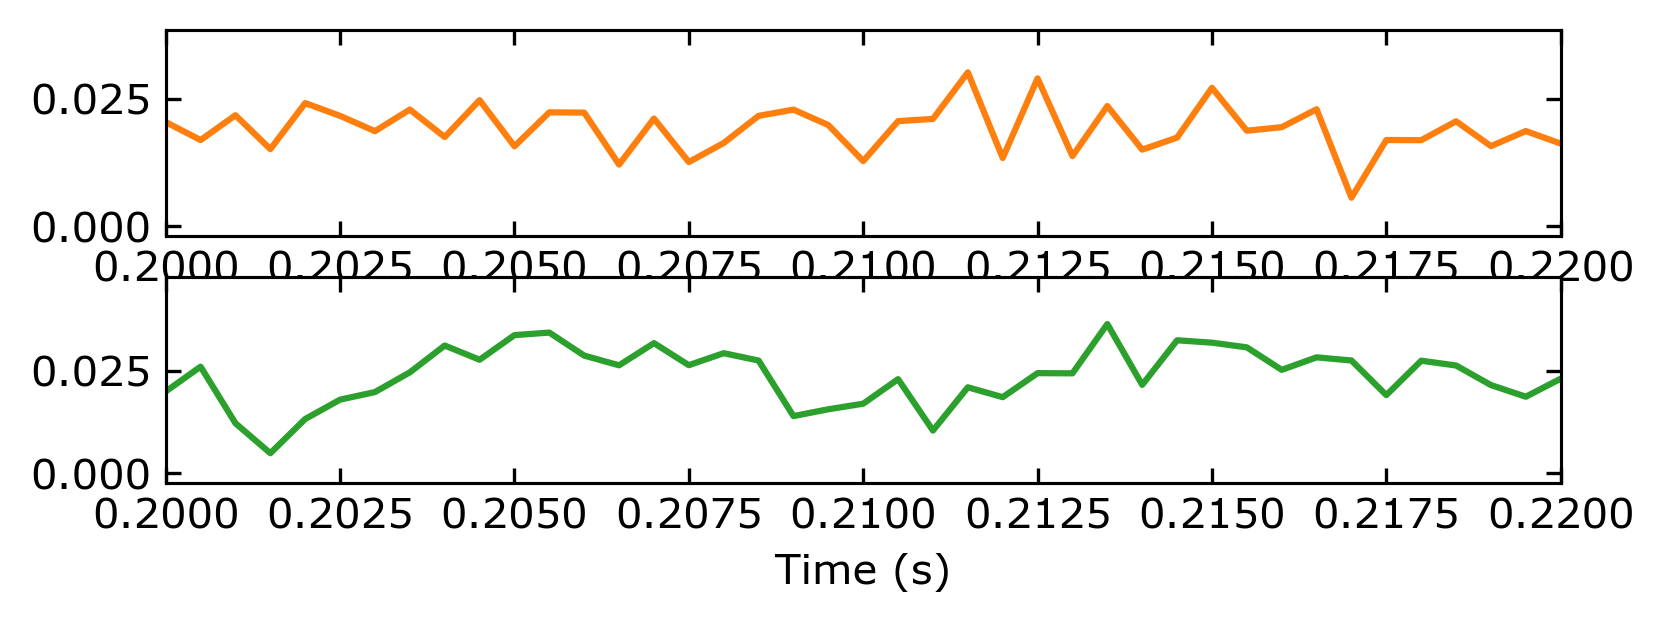

In [17]:
'''Plot signal waveform of sinusoidal voltage'''
# ['100mm0.4Hz7.0kV' '100mm0.6Hz7.0kV' '100mm1.6Hz7.0kV' '100mm1000.0Hz7.0kV' '100mm100.0Hz7.0kV' '100mm10.0Hz7.0kV'
#  '100mm12.6Hz7.0kV' '100mm125.9Hz7.0kV' '100mm15.8Hz7.0kV' '100mm158.5Hz7.0kV' '100mm1.0Hz7.0kV' '100mm2.5Hz7.0kV'
#  '100mm200.0Hz7.0kV' '100mm20.0Hz7.0kV' '100mm25.1Hz7.0kV' '100mm251.2Hz7.0kV' '100mm2.0Hz7.0kV' '100mm3.2Hz7.0kV'
#  '100mm31.6Hz7.0kV' '100mm316.2Hz7.0kV' '100mm398.1Hz7.0kV' '100mm40.0Hz7.0kV' '100mm4.0Hz7.0kV' '100mm50.1Hz7.0kV'
#  '100mm501.2Hz7.0kV' '100mm5.0Hz7.0kV' '100mm6.3Hz7.0kV' '100mm63.1Hz7.0kV' '100mm631.0Hz7.0kV' '100mm7.9Hz7.0kV'
#  '100mm79.4Hz7.0kV' '100mm794.3Hz7.0kV' ]

aSignal = nanoData.loc[(nanoData['Label'] == '100mm1.0Hz7.0kV'), 'Data'].values[0][0]
aSignal2 = nanoData.loc[(nanoData['Label'] == '100mm100.0Hz7.0kV'), 'Data'].values[0][0]
aSignal3 = nanoData.loc[(nanoData['Label'] == '100mm1000.0Hz7.0kV'), 'Data'].values[0][0]

aSignal = -aSignal[:,2] + np.amax(aSignal[:,2])
aSignal2 = -aSignal2[:,2] + np.amax(aSignal2[:,2])
aSignal3 = -aSignal3[:,2] + np.amax(aSignal3[:,2])

fig1, ax = plt.subplots(3,1,dpi=300, figsize=(6,3))
ax[0].plot(np.arange(aSignal.shape[0])/Fs, aSignal, 'C1')
ax[0].set_xlim([0, 10])
ax[0].set_ylim([0, 2.3])

ax[1].plot(np.arange(aSignal2.shape[0])/Fs, aSignal2, 'C2')
ax[1].set_xlim([0.2, 0.4])
ax[1].set_ylim([0, 1.2])
ax[1].set_ylabel('Force (N)')

ax[2].plot(np.arange(aSignal3.shape[0])/Fs, aSignal3, 'C3')
ax[2].set_xlim([0.2, 0.22])
ax[2].set_ylim([0, 0.2])
ax[2].set_xlabel('Time (s)')

fig1.savefig("force_time_sin1sin100sin1k.pdf", bbox_inches='tight')

'''Quick test for sampling rate and no-touch condition'''
# aSignal = nanoData.loc[(nanoData['Label'] == '100mm0.0Hz7.0kV'), 'Data'].values[0][0]
# aSignal = -aSignal[:,2] + np.amax(aSignal[:,2])

# aSignal2 = nanoData.loc[(nanoData['Label'] == '100mm100.0Hz7.0kV'), 'Data'].values[0][0]
# aSignal2 = -aSignal2[:,2] + np.amax(aSignal2[:,2])

# fig1, ax = plt.subplots(2,1,dpi=300, figsize=(6,2))
# ax[0].plot(np.arange(aSignal.shape[0])/Fs, aSignal, 'C1')
# ax[1].plot(np.arange(aSignal2.shape[0])/Fs, aSignal2, 'C2')
# for aaxis in ax:
#     aaxis.set_xlim([0.2, 0.22])
# #     aaxis.set_ylim([0, 0.22])
#     aaxis.set_xlabel('Time (s)')

In [ ]:
'''Plot signal waveform of DC voltage'''
# ['100mm3.0kV' '100mm4.0kV' '100mm5.0kV' '100mm6.0kV' '100mm7.0kV' 
#  '110mm3.0kV' '110mm4.0kV' '110mm5.0kV' '110mm6.0kV' '110mm7.0kV']

aSignal = nanoData.loc[(nanoData['Label'] == '100mm7.0kV'), 'Data'].values[0][0]
aSignal2 = nanoData.loc[(nanoData['Label'] == '100mm3.0kV'), 'Data'].values[0][0]

fig1, ax1 = plt.subplots(dpi=300, figsize=(5,2))

ax1.plot(np.arange(aSignal.shape[0])/Fs, -aSignal[:,2]+aSignal[0,2], 'C1')
ax1.plot(np.arange(aSignal2.shape[0])/Fs-1.94, -aSignal2[:,2]+aSignal2[0,2], 'C2')

ax1.set_xlim([0.2, 1.0])
ax1.set_ylim([0, 9])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Force (N)')

ax1.legend(labels=['7kV','3kV'], frameon=False, bbox_to_anchor=(1.0, 0.9), loc='upper left');

fig1.savefig("force_time_7kv3kv.pdf", bbox_inches='tight')

In [ ]:
'''
Analysis for Visualizing the Errorbar of one actuator type
'''
# labels = ['100mm3.0kV', '100mm4.0kV', '100mm5.0kV', '100mm6.0kV', '100mm7.0kV']
# # labels = ['110mm3.0kV', '110mm4.0kV', '110mm5.0kV', '110mm6.0kV', '110mm7.0kV']


# xTickLabel = [3, 4, 5, 6, 7]

# meanPeakF, stdPeakF = computeErrorbar1Var(dataFeature, 'Label', labels,'PeakForce')   
# meanRawPeakF, stdRawPeakF = computeErrorbar1Var(dataFeature, 'Label', labels,'RawPeakForce')  
# # meanAvgF, stdAvgF = computeErrorbar1Var(dataFeature, 'Label', labels, 'AvgForce')    
# meanTriseF, stdTriseF = computeErrorbar1Var(dataFeature, 'Label', labels, 'TriseForce')
 
# print(meanRawPeakF, stdRawPeakF)

# '''Visualize errorbar plot'''
# fig1, ax1 = plt.subplots(dpi=300, figsize=figSize_inch)  
# style = '.-'
# x = np.arange(len(labels))
# xLabel = 'Driven voltage (kV)'
# yLabelStr = ['20Hz-LP Filter','Raw Signal']
# zLabel = 'Force (N)'

# pltHandles = []
# pltHandles.append(ax1.plot(x, meanPeakF, style, c='C1')[0])    
# ax1.errorbar(x, meanPeakF, yerr=stdPeakF, fmt='none', ecolor='C1', capsize=0)

# pltHandles.append(ax1.plot(x, meanRawPeakF, style, c='C2')[0])    
# ax1.errorbar(x, meanRawPeakF, yerr=stdRawPeakF, fmt='none', ecolor='C2', capsize=0)

# ax1.set_xlabel(xLabel)
# ax1.set_xticklabels(xTickLabel);
# ax1.set_xticks(x);
# ax1.set_ylabel(zLabel, color='k')
# ax1.tick_params(axis='y', labelcolor='k')
# ax1.spines['bottom'].set_color('k')
# ax1.spines['top'].set_color('k') 
# ax1.spines['right'].set_color('k')
# ax1.spines['left'].set_color('k')

# ax1.tick_params(axis="y",direction="in")
# ax1.tick_params(axis="x",direction="in")

# ax1.legend(handles=(pltHandles), labels=(yLabelStr), frameon=False, bbox_to_anchor=(1.0, 0.9), loc='upper left');

# fig1.savefig("ForceNanoSensorSep_CompareVoltage.pdf", bbox_inches='tight')

In [ ]:
# ''' Compare biotac measurement against the energy model prediction'''
# simData = pd.read_csv("./data/EnModelResult08Mix.csv") # Data from model simulation

# simPFull = np.array(simData['PFull_Pa'].values, dtype=np.float64)
# print(simData['CondiName']);print(simPFull);

# ''' Convert pressure prediction to force assuming a contact area the same as the tip surface '''
# tipRadius = 7.6 # (mm) Radius of the actuator tip 
# tipAreaMeter = np.pi * (tipRadius*1e-3)**2
# simForce = simPFull * tipAreaMeter

# # ind = [0,1,2,5,4,9] # Select indices for comparing different tube lengths (with adjusted infill volumes)
# ind = [6,7,8,9,10] # Select indices for comparing different infill volumes given the same tube length

# fig1, ax1 = plt.subplots(dpi=300, figsize=figSize_inch)

# colors = sns.color_palette('Set2', n_colors=2)
# x = np.arange(len(ind))   
# style = '.'
# xLabel = 'Actuator'
# xTickLabel = [labels[l] for l in ind]
# yLabelStr = ['Peak Force', 'Time Avg. Force', 'Predicted Force Upper Bound (Time Avg.)']
# zLabel = 'Force (N)'

# pltHandles = []
# pltHandles.append(ax1.plot(x-0.02, meanPeakF[ind], style, c=colors[0])[0])    
# ax1.errorbar(x-0.02, meanPeakF[ind], yerr=stdPeakF[ind], fmt='none', ecolor=colors[0], capsize=0)

# pltHandles.append(ax1.plot(x+0.02, meanAvgF[ind], style, c=colors[1])[0])    
# ax1.errorbar(x+0.02, meanAvgF[ind], yerr=stdAvgF[ind], fmt='none', ecolor=colors[1], capsize=0)
    
# ax1.set_xlabel(xLabel)
# ax1.set_xticklabels(xTickLabel, rotation=-40, ha='left');
# ax1.set_xticks(x);
# ax1.set_ylabel(zLabel, color='k')
# ax1.tick_params(axis='y', labelcolor='k')
# ax1.spines['bottom'].set_color('k')
# ax1.spines['top'].set_color('k') 
# ax1.spines['right'].set_color('k')
# ax1.spines['left'].set_color('k')

# pltHandles.append(ax1.plot(x, simForce[ind], '--', color='tab:blue')[0])

# # ax1.legend(handles=(pltHandles), labels=(yLabelStr), frameon=False, bbox_to_anchor=(0.5, 1.2), loc='upper left');
# ax1.legend(handles=(pltHandles), labels=(yLabelStr), frameon=False, bbox_to_anchor=(0.9, 0.9), loc='upper left');

# ax1.tick_params(axis="y",direction="in")
# ax1.tick_params(axis="x",direction="in")

# ax1.set_ylim([0, 5.2])

# fig1.savefig("ForceNanoSensorAug_CompareInfillvolume.pdf", bbox_inches='tight')

In [ ]:
'''Plot a sinusoidal waveform'''
fig1, ax = plt.subplots(dpi=300, figsize=(10,1))
t = np.arange(0, 10, 1/Fs)
f = 1
y = np.sin(2*np.pi*f*t - np.pi/2)
ax.plot(t, y)

fig1.savefig("sinusoidal.pdf", bbox_inches='tight')